# Вебинар 3. Коллаборативная фильтрация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [2]:
data = pd.read_csv('./lessons/web2/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [3]:
item_features = pd.read_csv('./lessons/web2/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [8]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(
    data_train, 
    index='user_id',
    columns='item_id', 
    values='quantity',
    aggfunc='count', 
    fill_value=0
)

user_item_matrix = user_item_matrix.astype(float)
sparse_user_item = csr_matrix(user_item_matrix)
user_item_matrix.head(3)

C:\Users\konst\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

In [10]:
%%time

model = AlternatingLeastSquares(
    factors=100, 
    regularization=0.001,
    iterations=15, 
    calculate_training_loss=True, 
    num_threads=4
)

model.fit(
    csr_matrix(user_item_matrix).T,  # На вход item-user matrix
    show_progress=True
)

recs = model.recommend(
    userid=userid_to_id[2],  # userid - id от 0 до N
    user_items=csr_matrix(user_item_matrix).tocsr(),
    N=5, # кол-во рекомендаций 
    filter_already_liked_items=False, 
    filter_items=None, 
    recalculate_user=True
)

100%|██████████| 15/15 [00:31<00:00,  2.13s/it, loss=0.0409]
Wall time: 33.7 s


In [11]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 5569230, 1082185]

In [12]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [13]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 1min 30s


0.15827619980411362

In [14]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 901062, 995242, 979707, 1005186]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[929668, 1106523, 1133018, 859075, 910032]"


### Embeddings

In [15]:
model.item_factors.shape

(5001, 100)

In [16]:
model.user_factors.shape

(2499, 100)

In [17]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [18]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [19]:
model.item_factors.shape

(5001, 100)

In [20]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [21]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


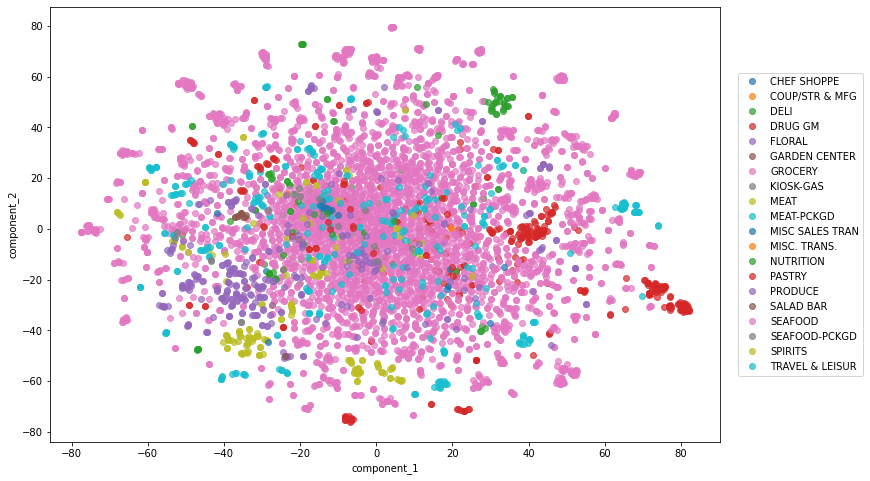

Wall time: 1min 33s


In [22]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

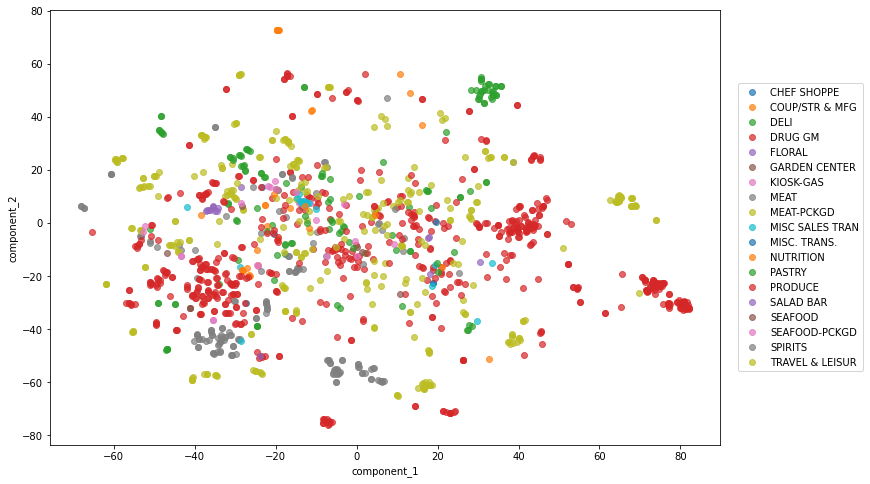

In [23]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

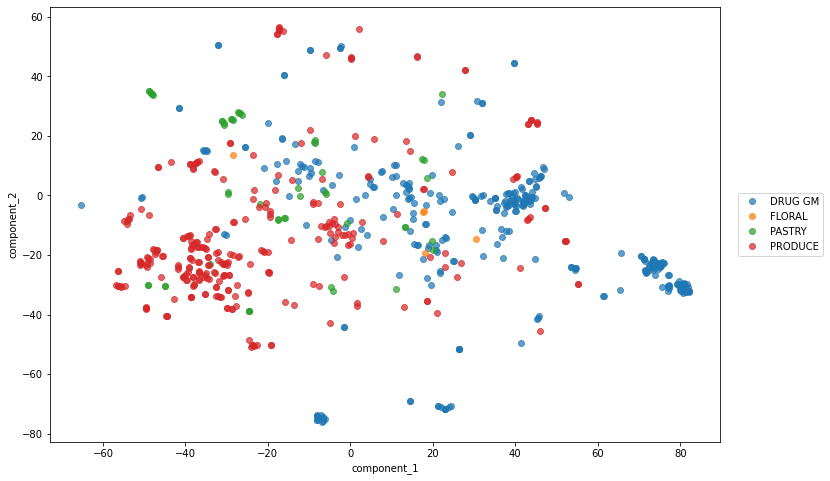

In [24]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

In [25]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

100%|██████████| 2499/2499 [01:11<00:00, 35.20it/s]Wall time: 1min 11s



In [26]:
recommendations.shape

(2499, 5)

In [27]:
recommendations

array([[3031, 3616, 1927,  832, 3947],
       [2148, 2307, 4346, 2927,  215],
       [1516,  558, 1242, 3029, 3388],
       ...,
       [4346, 3587, 1349, 2148, 3737],
       [ 300, 2847, 1908,  845, 3704],
       [ 558, 2454, 2216, 2434,  575]], dtype=int32)

In [28]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [29]:
item_1.shape

(100,)

*Посмотрите также / Похожие товары*

In [30]:
example_item_row_id = 3606

In [31]:
id_to_itemid[example_item_row_id]

1100265

In [32]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [33]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8143,839040,942,GROCERY,National,CONDIMENTS/SAUCES,HOT MUSTARD/SPECIALTY MUSTAR,12 OZ
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
38391,1107824,544,GROCERY,National,WAREHOUSE SNACKS,SNACK MIX,7.75 OZ
39005,1113385,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,13 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [34]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0),
 (790, 0.9737695),
 (239, 0.97294927),
 (1380, 0.97235286),
 (354, 0.9710612)]

### 2. TF-IDF взвешивание

In [35]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [36]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


100%|██████████| 15/15 [00:24<00:00,  1.67s/it, loss=0.0687]Wall time: 25.1 s



In [37]:
result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.16787463271302644

### 3. BM25 взвешивание

In [38]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
user_item_matrix.head(3)

C:\Users\konst\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [40]:
%%time

model = AlternatingLeastSquares(factors=128, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

100%|██████████| 15/15 [00:21<00:00,  1.43s/it, loss=0.0749]
Wall time: 2min 7s


In [41]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.19686581782566115

In [42]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

In [43]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [44]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
def prefilter_items(data, item_features, interesting_cats):

    data_ = data.copy()

    # Уберем самые популярные товары (их и так купят)
    popularity = data_.groupby('item_id')['user_id'].nunique().reset_index() / data_['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data_ = data_[~data_['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data_ = data_[~data_['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    data_ = data_[~(data_['day'] > 365)]

    # Уберем не интересные для рекоммендаций категории (department)
    items_of_interest = item_features[item_features['department'].isin(interesting_cats)]
    data_ = pd.merge(data_, items_of_interest, on='item_id', how='inner')

    data_['price'] = data_['sales_value'] / (np.maximum(data_['quantity'], 1))

    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data_ = data_[~(data_['price'] < data_['price'].quantile(0.20))]

    # Уберем слишком дорогие товары
    data_ = data_[~(data_['price'] > data_['price'].quantile(0.99995))]

    return data_
    
def postfilter_items(user_id, recommednations):
    pass

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

## Практика:

4) Поэкспериментировать с ALS (grid-search)

А точно нужно сортировать по вероятности?

Какую метрику использовать?

Сколько раз в неделю отпрпавляем рассылку?

В какое время отправляем рассылку?

Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?

Нужно ли, чтобы в одной рассылке были разные товары? Как определить, что товары разные? Как добиться того, чтобы они были разными?

* Я бы сказал что нет, тк исключаются товары, которые пользователь никогда не видел/ не кликал, но мог бы купить
* 
* Если покупки периодические, наример, продукты, то можно рассылать накануне дня, когда чаще всего юзер покупает (пятница к примеру, в магазин на выходных или в день "икс"). Когда покупки носят спонтанный характер, тогда, кмк, все равно... 
* Середниа дня, наверное, оптимальное (по времени тоже, наверное, можно подстроится относительно того, когда юзер совершает покупки чаще)
* Подмешивать какие-то похожие товары из наиболее популярных за последний промежуток времени(за последние 1-2 недели, к примеру), добавлять акционные товары, накануне праздников тематическое товары, новые товары
* Делать рекомендацию, в который будет акционная картошка и новый айфон, наверное, не стоит, по крайней-мере на регулярной основе =)) А вот накануне праздников, может и зайдет. Но я бы придерживался в одной рекомендации близких групп товаров (одежда + обувь / продукты питания + напитки и тд)

## Подбор параметров для ALS

In [71]:
import datetime
from sklearn.model_selection import ParameterGrid


def grid_search(param_grid: dict, data: pd.DataFrame) -> dict:
    data_temp = data.copy()
    time: datetime.datetime = datetime.datetime.now()
    results: dict = dict()
    grid: list = list(ParameterGrid(param_grid))
    cnt: int = 0
    for params in grid:
        cnt += 1
        results[cnt] = params
        
        model = AlternatingLeastSquares(
            calculate_training_loss=True, 
            num_threads=4,
            **params
        )
        model.fit(
            csr_matrix(user_item_matrix).T.tocsr(),
            show_progress=False,
        )

        data_temp['als_bm25'] = data_temp['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precision = data_temp.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
        results[cnt].update({'precision_at_k': precision})

        print(f'Iteration {cnt} from {len(grid)} {datetime.datetime.now()} (spent {datetime.datetime.now() - time})')
        print(results[cnt])
        time = datetime.datetime.now()

    return results

param_grid = {
    'factors': [64, 96, 128], 
    'regularization': [0.25, 0.05, 1],
    'iterations': [10, 15, 20], 
}
results = grid_search(param_grid, result)

Iteration 1 from 27 2021-06-13 10:14:32.689908 (spent 0:00:45.012973)
{'factors': 64, 'iterations': 10, 'regularization': 0.25, 'precision_at_k': 0.18276199804113616}
Iteration 2 from 27 2021-06-13 10:15:18.926256 (spent 0:00:46.235348)
{'factors': 64, 'iterations': 10, 'regularization': 0.05, 'precision_at_k': 0.17659157688540647}
Iteration 3 from 27 2021-06-13 10:16:02.911685 (spent 0:00:43.984431)
{'factors': 64, 'iterations': 10, 'regularization': 1, 'precision_at_k': 0.18021547502448582}
Iteration 4 from 27 2021-06-13 10:16:57.322505 (spent 0:00:54.410820)
{'factors': 64, 'iterations': 15, 'regularization': 0.25, 'precision_at_k': 0.18099902056807052}
Iteration 5 from 27 2021-06-13 10:17:48.687917 (spent 0:00:51.364416)
{'factors': 64, 'iterations': 15, 'regularization': 0.05, 'precision_at_k': 0.1835455435847209}
Iteration 6 from 27 2021-06-13 10:18:41.675926 (spent 0:00:52.987010)
{'factors': 64, 'iterations': 15, 'regularization': 1, 'precision_at_k': 0.18060724779627815}
Itera

In [72]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='precision_at_k', ascending=False)

,factors,iterations,regularization,precision_at_k
20,128,10,0.05,0.206268
23,128,15,0.05,0.199216
19,128,10,0.25,0.197747
21,128,10,1.00,0.197551
22,128,15,0.25,0.197453
25,128,20,0.25,0.196768
26,128,20,0.05,0.196278
27,128,20,1.00,0.195299
11,96,10,0.05,0.194515
24,128,15,1.00,0.193242
